<a href="https://colab.research.google.com/github/kfahn22/computer-vision-course/blob/labeled-image-demo/labeled_image_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating a Simple Labeled Dataset

In this notebook, we are going to demo how to create a toy dataset of labeled  cellular automaton images.

[Cellular Automaton](https://mathworld.wolfram.com/ElementaryCellularAutomaton.html) were described by Stephen Wolphram in [A New King of Science](https://www.wolframscience.com/nks/).  Imagine you have a grid, like a checkerboard. Each square in the grid has a state - on or off, with the state of the square determining its color. There are rulesets (256 of them) that describe how the squares change their state depending on what's happening around them.

[CellPyLib](https://github.com/lantunes/cellpylib) is a python library for working with Cellular Automata. We will use it to generate the labeled images.




Run this cell if you have generated a large dataset. It is unnecessary for this toy example.

In [20]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


First, let's install the dependencies.

In [1]:
!pip install cellpylib huggingface_hub datasets

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for cellpylib: filename=cellpylib-2.4.0-py3-none-any.whl size=37921 sha256=6c9bccb01c3853d820b699e5142396093e5bf43e239ab1ce5d5a73b0c983ffd8
  Stored in directory: /root/.cache/pip/wheels/44/bc/c4/4730d328071b164c25d392c2d932b513e56ff0857da63d17e7
Successfully built cellpylib


Let's log into the Hugging Face Hub with our WRITE access token.

In [2]:
from huggingface_hub import notebook_login

notebook_login()


The CellPyLib library uses [Matplotlib](https://matplotlib.org/) to plot the images. We can add color to the images by specifying the [colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html). Since some of the colormaps yield uninteresting images or duplicate another colormap, we are only going to use a subset of the colormaps available in Matplotlib.

In [3]:
colorOptions = [
 'inferno',
 'viridis',
 'cividis',
 'turbo',
 'Blues',
 'BuPu',
 'BrBG',
 'CMRmap',
 'GnBu',
 'OrRd',
 'PiYG',
 'PRGn',
 'PuOr',
 'PuRd',
 'RdBu',
 'RdGy',
 'RdPu',
 'RdYlBu',
 'Reds',
 'Spectral',
 'Wistia',
 'YlGn',
 'YlGnBu',
 'YlOrBr',
 'YlOrRd',
 'autumn',
 'brg',
 'bwr',
 'cool',
 'coolwarm',
 'copper',
 'flag',
 'gnuplot',
 'jet',
 'ocean',
 'prism',
 'rainbow',
 'seismic',
 'spring',
 'summer',
 'winter',
 'Accent',
 'Dark2',
 'Paired',
 'Set1',
 'tab10',
 'tab20',
 'tab20b',
 'tab20c',
 ]

We will add the images to a "generated_images" folder and then load this folder to the Hugging Face Hub.

In [4]:
import os
generated_images_dir = "/content/generated_images"
os.makedirs(generated_images_dir, exist_ok=True)

Now we will add a function to write a metadata.jsonl file.  This dictionary will contain the filename (the key *must* named be "file_name") and associated text label.

In [5]:
# Create a metadata_file
def metadata_file(filename, label, output_path):
    with open(output_path, 'a') as file:

            # Create a dictionary with file and text label
            metadata_entry = {"file_name": filename, 'text': label}

            # Write the entry to the file as a JSON line
            file.write(json.dumps(metadata_entry) + '\n')

This next cell defines a function to create the celluar automata.

In [6]:
def init_automata(ruleset, cells):
      # we input the number of cells, which will determine the resolution of the image
      # we will use a square aspect ratio, but you can adjust height by changing timesteps to a different number
      ca = cpl.init_simple(cells)
      # Initialize the cellular automata with a random initial ruleset
      ca = cpl.evolve(ca, timesteps=cells, memoize=True,
                                      apply_rule=lambda n, c, t: cpl.nks_rule(n, ruleset))
      return ca

We will write a function to add a label to the image.

In [9]:
# Function to add label to image based on random ruleset and colormap
def label_automata(ruleset, col):
    return f'a cellular automata with ruleset {ruleset} and colormap {col}'

The default size of the grid in Matplotlib is small, so we will write a utility function to rescale the image using the PIL library.

In [7]:
# Add a function to rescale the images
def rescale_image(image_path, scale_factor):
    image = Image.open(image_path)
    width = int(image.width * scale_factor)
    height = int(image.height * scale_factor)
    upscaled_image = image.resize((width, height), resample=Resampling.LANCZOS)
    upscaled_image.save(image_path)

We now have all of the pieces in place to add the images to our dataset.  

  0%|          | 0/10000 [00:00<?, ?it/s]

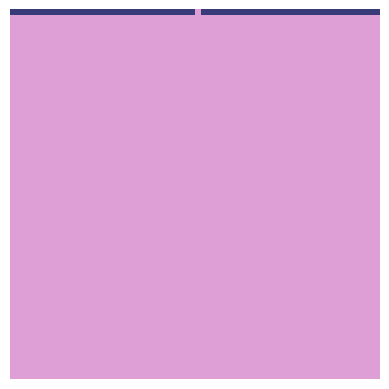

In [19]:
import random
import numpy as np
import cellpylib as cpl
import matplotlib.pyplot as plt
from PIL import Image
from PIL.Image import Resampling
import json
from tqdm.auto import tqdm

# Rulesets are 0 through 255
ruleset = random.randint(0, 255)
# Original resolution of image
cells = 64

# Specify the number of images to generate
num_images_to_generate = 100

# Specify the output file path for metadata.jsonl file
output = 'generated_images/metadata.jsonl'

def add_image(idx, ruleset, colmap):
      # Initialize the cellular automata with a random initial state
      ca = init_automata(ruleset, cells)

      # Since we are only interested in the image, we turn off the axis
      plt.axis('off')

      # Set the colormap
      plt.set_cmap(colmap)
      # Save the image to the generated_images folder
      path = f'generated_images/{idx}.png'
      # Save the image
      plt.imsave(path, ca, cmap=colmap)
      rescale_image(path, 2)

      # Display the image
      plt.imshow(ca, cmap=colmap)

      # Our metadata.jsonl file takes a filename and label
      # Generate a filename for the image
      filename = f'{idx}.png'
      # Generate a label for the image
      label = label_automata(ruleset, colmap)

      # Write the metadata.jsonl file
      metadata_file(filename, label, output)

# Add images to dataset
for i in tqdm(range(num_images_to_generate)):
    ruleset = random.randint(0, 255)
    col = random.choice(colorOptions)
    add_image(i, ruleset, col)

We are now ready to load the generated images and upload them to the Hugging Face Hub. You can read more about uploading an image dataset to the Hugging Face Hub [here](https://huggingface.co/docs/datasets/image_dataset).

In [21]:
from datasets import load_dataset
dataset = load_dataset("imagefolder", data_dir="generated_images")

Resolving data files:   0%|          | 0/10001 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
user_name = "kfahn"
repo_name = "cellular_automata"

In [23]:
dataset.push_to_hub(f"{user_name}/{repo_name}")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/100 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/kfahn/cellular_automata/commit/62945cb377a0e49bce92e100d297e4f2b5936cea', commit_message='Upload dataset', commit_description='', oid='62945cb377a0e49bce92e100d297e4f2b5936cea', pr_url=None, pr_revision=None, pr_num=None)

If desired, we can do a test download of our new labeled image dataset.

In [24]:
from datasets import load_dataset
dataset = load_dataset("kfahn/cellular_automata")


Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Let's take a look at one of the downloaded images.

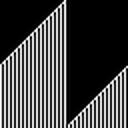

In [25]:
dataset['train'][0]['image']

Now let's look at the label.

In [26]:
dataset['train'][0]['text']

'a cellular automata with ruleset 198 and colormap CMRmap'